<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/adaptive_cycle_gan_malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the additional Tensorflow extension packages

In [ ]:
!pip install -q tensorflow-probability
!pip install -q tensorflow_addons
!pip install sewar

     |████████████████████████████████| 1.1 MB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=9fff4e610f812af93cb08c150076f74ccb2d114fb08b824046909c60c5225edb
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display
from zipfile import ZipFile
import glob
import imageio
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import pathlib
import shutil
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

AUTOTUNE = tf.data.AUTOTUNE

Prepare the malaria blood cell dataset

In [ ]:
if not os.path.exists('malaria.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/malaria.zip ./malaria.zip

with ZipFile('malaria.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-08-26 16:43:37--  https://storage.googleapis.com/pet-detect-239118/malaria.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63432592 (60M) [application/x-zip-compressed]
Saving to: ‘malaria.zip’

malaria.zip         100%[===================>]  60.49M  41.4MB/s    in 1.5s    

2022-08-26 16:43:39 (41.4 MB/s) - ‘malaria.zip’ saved [63432592/63432592]

--2022-08-26 16:43:39--  http://./malaria.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-26 16:43:39--
Total wall clock time: 2.3s
Downloaded: 1 files, 60M in 1.5s (41.4 MB/s)


In [ ]:
data_dir = './malaria'
data_dir = pathlib.Path(data_dir)
blood_imgs = list(data_dir.glob('*/*.png'))

print(f'There are {len(blood_imgs)} in total.')

There are 24820 in total.


Separate the positive and negative images

In [ ]:
positive_paths = []
negative_paths = []
for file in blood_imgs:
  file = str(file)
  parts = tf.strings.split(file, os.path.sep)
  if parts[-2] == 'Parasitemic':
    positive_paths.append('/content/'+file)
  else:
    negative_paths.append('/content/'+file)


take 8,000 images from each class

In [ ]:
positive_paths = positive_paths[:8000]
negative_paths = negative_paths[:8000]

In [ ]:
total = len(positive_paths)
test_idx = np.random.choice(total, 1000, replace=False)

In [ ]:
positive_paths = np.array(positive_paths)
negative_paths = np.array(negative_paths)
test_positive = np.take(positive_paths, test_idx, axis=0)
train_positive = np.delete(positive_paths, test_idx, axis=0)
test_negative = np.take(negative_paths, test_idx, axis=0)
train_negative = np.delete(negative_paths, test_idx, axis=0)

train_images = np.concatenate((train_positive, train_negative), axis=0)
test_images = np.concatenate((test_positive, test_negative), axis=0)
print(train_images.shape)
print(test_images.shape)

(14000,)
(2000,)


copy the images to the correct folder

In [ ]:
if not os.path.exists('train'):
  os.mkdir('train')

if not os.path.exists('test'):
  os.mkdir('test')

os.mkdir('train/Parasitemic')
os.mkdir('test/Parasitemic')
os.mkdir('train/Uninfected')
os.mkdir('test/Uninfected')
os.mkdir('gen_images')

In [ ]:
for file in train_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/train'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

for file in test_images:
  parts = str.split(file, os.path.sep)
  cp_path = parts[-2]+'/'+parts[-1]
  root = '/content/test'+'/'
  dest = root+cp_path
  src = file
  shutil.copy2(src, dest)

Helper functions for making the dataset

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32, 32])

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  if parts[-2] == 'Parasitemic':
    return tf.constant(1.0, dtype="float64")
  else:
    return tf.constant(0.0, dtype="float64")


def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  # rescale from (0,255) to (0,1)
  # img = img / 255.0
  img = (img - 127.5) / 127.5
  return img, label

Load the pretrained classifier

In [ ]:
!wget https://storage.googleapis.com/pet-detect-239118/classify_malaria_32.zip ./classify_malaria_32.zip

--2022-08-26 16:45:44--  https://storage.googleapis.com/pet-detect-239118/classify_malaria_32.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3777705 (3.6M) [application/x-zip-compressed]
Saving to: ‘classify_malaria_32.zip’

classify_malaria_32 100%[===================>]   3.60M  --.-KB/s    in 0.01s   

2022-08-26 16:45:45 (299 MB/s) - ‘classify_malaria_32.zip’ saved [3777705/3777705]

--2022-08-26 16:45:45--  http://./classify_malaria_32.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-26 16:45:45--
Total wall clock time: 0.2s
Downloaded: 1 files, 3.6M in 0.01s (299 MB/s)


In [ ]:
with ZipFile('classify_malaria_32.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
classifier = tfk.models.load_model('classify_malaria_32')
classifier.trainable = False

Build the classify dataset for classification

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 3000

classify_dataset = tf.data.Dataset.list_files("/content/train/*/*.png")
classify_dataset = classify_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
classify_dataset = classify_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files("/content/test/*/*.png")
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

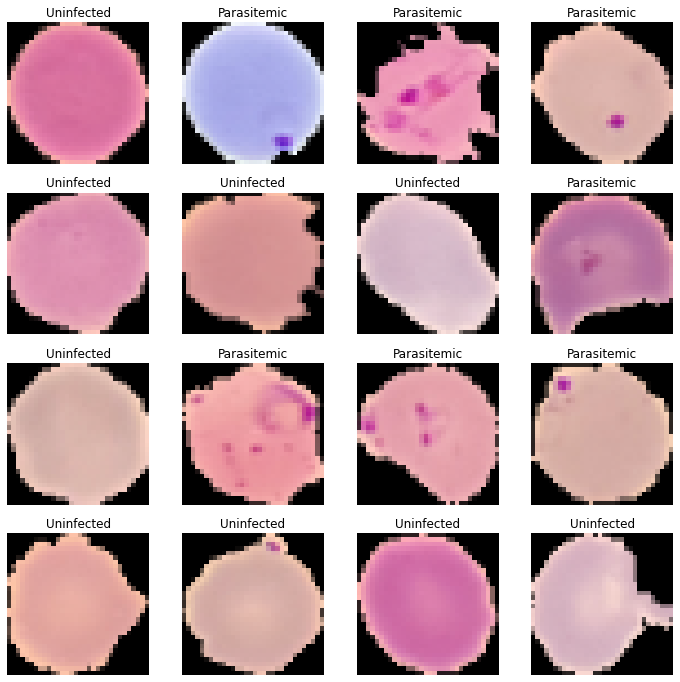

In [ ]:
show_images, labels = next(iter(classify_dataset))

plt.figure(figsize=(12,12))


for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  image = tf.keras.preprocessing.image.array_to_img(show_images[i,:,:,:])
  plt.imshow(image)
  if labels[i] == 1.0:
    plt.title('Parasitemic')
  else:
    plt.title('Uninfected')

In [ ]:
classifier.evaluate(classify_dataset)

55/55 [==============================] - 12s 34ms/step - loss: 0.0366 - accuracy: 0.9915


[0.03655090183019638, 0.9915000200271606]

In [ ]:
classifier.evaluate(test_dataset)

8/8 [==============================] - 11s 24ms/step - loss: 0.0562 - accuracy: 0.9885


[0.05615592375397682, 0.9884999990463257]

Load the pretrained VAE model 

In [ ]:
if not os.path.exists('CVA_encoder2_32.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/CVA_encoder2_32.zip ./CVA_encoder2_32.zip

with ZipFile('CVA_encoder2_32.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-08-26 00:14:26--  https://storage.googleapis.com/pet-detect-239118/CVA_encoder2_32.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568987 (2.4M) [application/x-zip-compressed]
Saving to: ‘CVA_encoder2_32.zip’

CVA_encoder2_32.zip 100%[===================>]   2.45M  --.-KB/s    in 0.009s  

2022-08-26 00:14:27 (277 MB/s) - ‘CVA_encoder2_32.zip’ saved [2568987/2568987]

--2022-08-26 00:14:27--  http://./CVA_encoder2_32.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-26 00:14:27--
Total wall clock time: 0.5s
Downloaded: 1 files, 2.4M in 0.009s (277 MB/s)


In [ ]:
if not os.path.exists('CVA_decoder2_32.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/CVA_decoder2_32.zip ./CVA_decoder2_32.zip

with ZipFile('CVA_decoder2_32.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

--2022-08-26 00:14:29--  https://storage.googleapis.com/pet-detect-239118/CVA_decoder2_32.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 803515 (785K) [application/x-zip-compressed]
Saving to: ‘CVA_decoder2_32.zip’

CVA_decoder2_32.zip 100%[===================>] 784.68K  --.-KB/s    in 0.004s  

2022-08-26 00:14:30 (170 MB/s) - ‘CVA_decoder2_32.zip’ saved [803515/803515]

--2022-08-26 00:14:30--  http://./CVA_decoder2_32.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-26 00:14:30--
Total wall clock time: 0.4s
Downloaded: 1 files, 785K in 0.004s (170 MB/s)


In [ ]:
# VAE cost function as negative ELBO (Evidence Lower Bound Objective)

def normal_log_pdf(sample, mean, sd, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  logvar = np.log((np.square(sd)))
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def vae_cost(x_true, model, analytic_kl=True, kl_weight=0.01):
  z_sample, mu, sd = model.encode(x_true)
  x_recons_logits = model.decoder(z_sample)
  # compute cross entropy loss for each dimension of every datapoint
  raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits) # bs*64*64*3
  # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,), the first term of the objective
  neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3]) # the first term of the objective

  # compute reverse KL divergence, either analytically or through MC approximation with one sample, the second term of the objective
  if analytic_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd), axis=1)  # shape=(batch_size, )
  else:
    logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
    logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
    kl_divergence = logqz_x - logpz
  elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
  return -elbo

In [ ]:
class VAE(tfk.Model):

    def __init__(self, dim_z, learning_rate, seed=2000, name="autoencoder", **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.dim_x = (32, 32, 3)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.seed = seed

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.dim_z))
      return self.decode(eps, apply_sigmoid=True)


    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1 + tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  z, mean, logvar = model.encode(test_sample)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    plt.subplot(4, 4, i + 1)
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.imshow(show_img)
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
CVA_model = VAE(128, 2e-4)
CVA_model.encoder = tfk.models.load_model('CVA_encoder2_32')
CVA_model.decoder = tfk.models.load_model('CVA_decoder2_32')

In [ ]:
# rescale the image tensor from [-1,1] to [0,1]
# @tf.function
def CVA_rescale(image_tensor):
  img = tf.multiply(image_tensor, 127.5)
  img = tf.add(img, 127.5)
  img = tf.divide(img, 255.0)
  return img

A dataset with parasitemic images only

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 8000

positive_dataset = tf.data.Dataset.list_files("/content/train/Parasitemic/*.png")
positive_dataset = positive_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
positive_dataset = positive_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

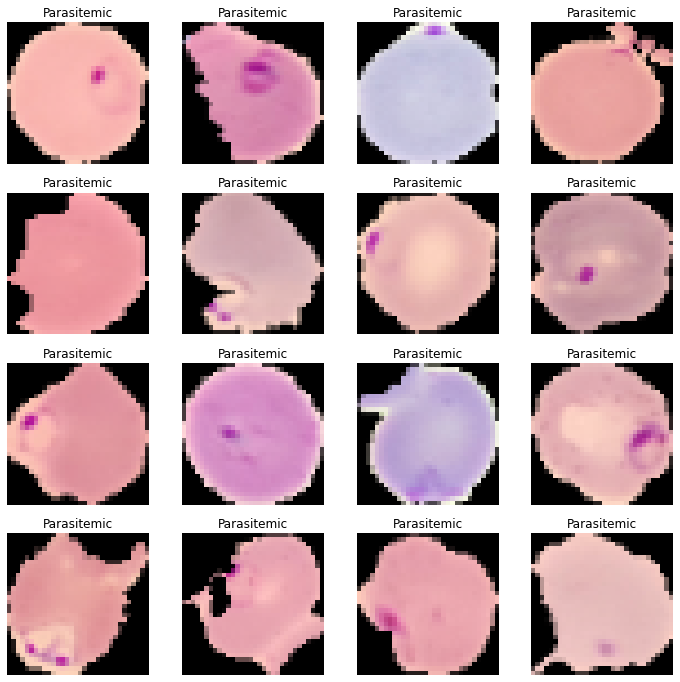

In [ ]:
show_images, labels = next(iter(positive_dataset))

plt.figure(figsize=(12,12))


for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  image = tf.keras.preprocessing.image.array_to_img(show_images[i,:,:,:])
  plt.imshow(image)
  if labels[i] == 1.0:
    plt.title('Parasitemic')
  else:
    plt.title('Uninfected')

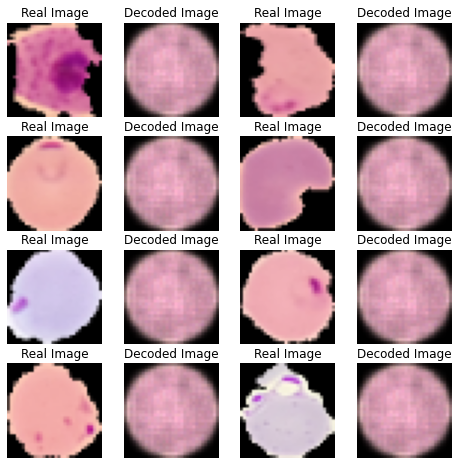

In [ ]:
input_CVA = CVA_rescale(show_images) # rescale to [0,1]
z, mean, logvar = CVA_model.encode(input_CVA)
predictions = CVA_model.sample(z)
fig = plt.figure(figsize=(8, 8))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  if i % 2 == 0:
    show_img = tf.keras.preprocessing.image.array_to_img(input_CVA[i, :, :, :])
    plt.title('Real Image')
    plt.imshow(show_img)
    plt.axis('off')
  else:
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.title('Decoded Image')
    plt.imshow(show_img)
    plt.axis(False)


In [ ]:
input_images = []
generated_images = []
for i in range(input_CVA.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(input_CVA[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []


for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

In [ ]:
MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 2887.0805587768555, std: 1625.8115672760305 
RMSE: ---- mean: 52.03454452368091, std: 13.397265952048743 
PSNR: ---- mean: 14.063311643221464, std: 2.0721062685496108 
UQI: ---- mean: 0.9414064851611981, std: 0.05233342869758038 
SCC: ---- mean: 0.1529934220340771, std: 0.08639260558838631 
RASE: ---- mean: 1524.1739380084828, std: 481.23025431830155 
SAM: ---- mean: 0.32112622586549955, std: 0.09893758847270137 
VIF: ---- mean: 0.10481678155632543, std: 0.02820394259163644 


In [ ]:
def get_accuracy(g_true, preds):
  pred_idx = tf.argmax(preds, axis=1).numpy()
  count = 0
  for tab, pred in zip(g_true, pred_idx):
    if tab == pred:
      count += 1
  return count / preds.shape[0]

In [ ]:
class_loss = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)

Classify the CAV generated images

In [ ]:
preds = classifier(predictions)
print(f"classify accuracy: {get_accuracy(labels, preds)}")

NameError: ignored

Classify the real images

In [ ]:
images, labels = next(iter(classify_dataset))
preds = classifier(images)
print(f"classify accuracy: {get_accuracy(labels, preds)}")

classify accuracy: 0.99609375


Set the two image domains

In [ ]:
def process_gan_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = (img - 127.5) / 127.5
  return img

In [ ]:
y_dataset = tf.data.Dataset.list_files("/content/train/Parasitemic/*.png")
x_dataset = tf.data.Dataset.list_files("/content/train/Uninfected/*.png")

In [ ]:
BUFFER_SIZE = 8000
BATCH_SIZE = 256

x_dataset = x_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE)
x_dataset = x_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
y_dataset = y_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE)
y_dataset = y_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
y_testset = tf.data.Dataset.list_files("/content/test/Parasitemic/*.png")
x_testset = tf.data.Dataset.list_files("/content/test/Uninfected/*.png")

y_testset = y_testset.map(process_gan_path, num_parallel_calls=AUTOTUNE)
y_testset = y_testset.shuffle(2000).batch(256)
x_testset = x_testset.map(process_gan_path, num_parallel_calls=AUTOTUNE)
x_testset = x_testset.shuffle(2000).batch(256)

# Set the Cycle GAN model

Define the Generator and Discriminator

In [ ]:
# define the discriminator model
def define_discriminator(image_shape=(32,32,3)):
  init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
  in_image = tf.keras.Input(shape=image_shape)
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image) # 16*16*64
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 8*8*128
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 4*4*256
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d) # 4*4*512
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # 4*4*1
  model = tf.keras.Model(inputs=in_image, outputs=patch_out)
  return model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tfkl.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tfkl.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def define_generator():
  inputs = tf.keras.layers.Input(shape=[32, 32, 3])

  down_stack = [
    downsample(64, 4),  # (bs, 16, 16, 64)
    downsample(128, 4),  # (bs, 8, 8, 128)
    downsample(256, 4),  # (bs, 4, 4, 256)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (bs, 2, 2, 512)
    upsample(256, 4),  # (bs, 4, 4, 256)
    upsample(128, 4),  # (bs, 8, 8, 256)
    upsample(64, 4),  # (bs, 16, 16, 128)

  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 64, 64, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
image_shape = (32,32,3)

generator_g = define_generator()
generator_f = define_generator()
discriminator_x = define_discriminator(image_shape)
discriminator_y = define_discriminator(image_shape)

In [ ]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 instance_normalization_18 (  (None, 8, 8, 128)        256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                           

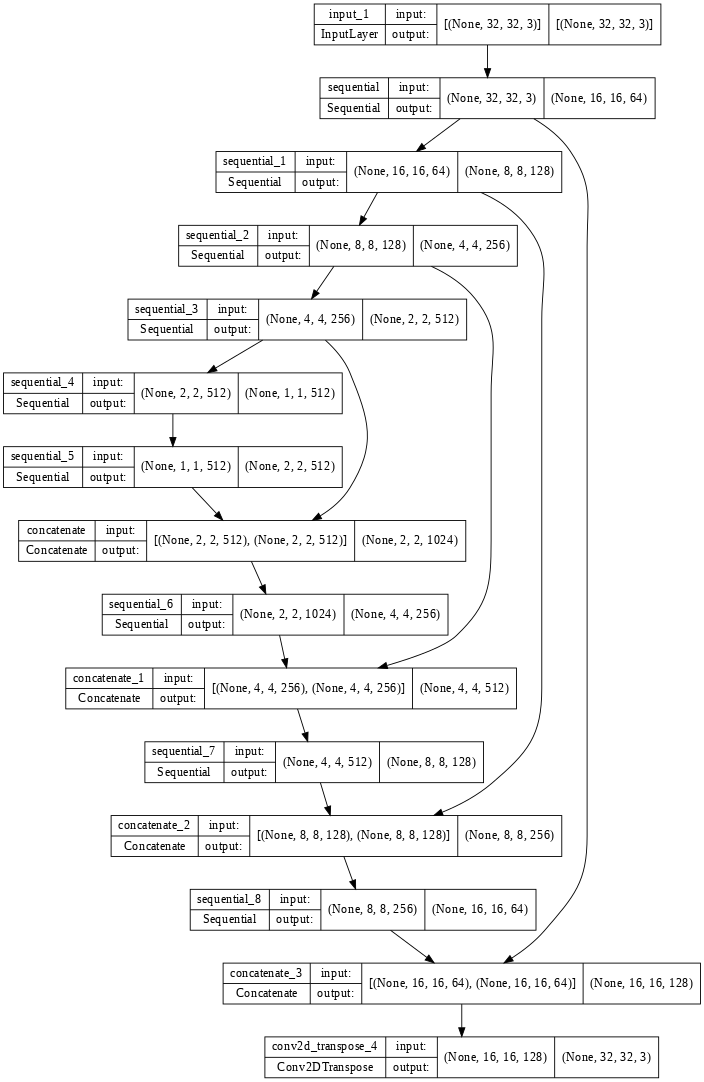

In [ ]:
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

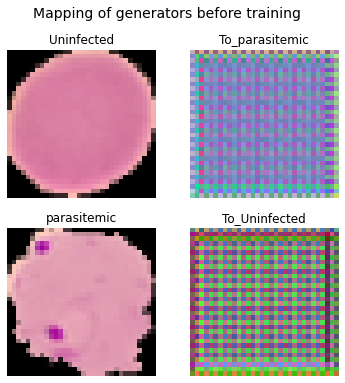

In [ ]:
# x -> y: normal -> infected - generator_g
# y -> x: infected -> normal - generator_f

x_images = next(iter(x_dataset))
y_images = next(iter(y_dataset))

to_para = generator_g(x_images)
to_normal = generator_f(y_images)
plt.figure(figsize=(6, 6))

imgs = [x_images, to_para, y_images, to_normal]
title = ['Uninfected', 'To_parasitemic', 'parasitemic', 'To_Uninfected']

plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[0][0]))
plt.suptitle("Mapping of generators before training", fontsize=14)
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  plt.axis(False)
  if i % 2 == 0:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
  else:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
plt.show()

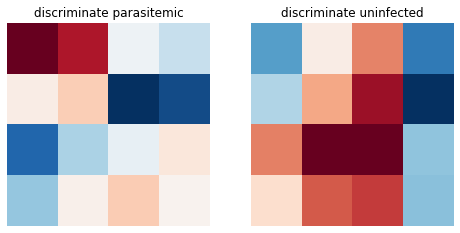

In [ ]:
# the hotmap of untrained discriminator
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('discriminate parasitemic')
plt.axis(False)
plt.imshow(discriminator_y(y_images)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('discriminate uninfected')
plt.axis(False)
plt.imshow(discriminator_x(x_images)[0, ..., -1], cmap='RdBu_r')
plt.show()

Setup the folder for generated images

Define the loss functions for the GAN components

In [ ]:
LAMBDA = 80
# alternative: MSE
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss_obj = tfk.losses.MeanSquaredError()

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1


# prevser color
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * loss * 0.8

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 600

def generate_images(model, test_input, epoch):
  prediction = model(test_input)
  idx = int(np.random.choice(16, 1, replace=False))
  plt.figure(figsize=(10, 10))
  

  display_list = [test_input[idx], prediction[idx]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.savefig('./gen_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def classify_para_loss(y, batch_size):
  true_para = tf.ones([batch_size,1])
  pred = classifier(y)
  return class_loss(true_para, pred) * 0.5


def classify_normal_loss(x, batch_size):
  true_normal = tf.zeros([batch_size,1])
  pred = classifier(x)
  return class_loss(true_normal, pred) * 0.5

In [ ]:
# @tf.function
def train_step(real_x, real_y, epoch, c_flag=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  batch_size = real_x.shape[0]
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    c_loss_x = classify_normal_loss(same_x, batch_size) + classify_normal_loss(cycled_x, batch_size)
    c_loss_x = c_loss_x * 0.1
    c_loss_y = classify_para_loss(same_y, batch_size) + classify_para_loss(cycled_y, batch_size)
    c_loss_y = c_loss_y * 0.1
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # if epoch > 50 and epoch < 100:
    #   c_loss_x = c_loss_x * 1.0
    #   c_loss_y = c_loss_y * 1.0
    #   total_cycle_loss = total_cycle_loss * 1.0

    # if epoch >= 100 and epoch < 200:
    #   c_loss_x = c_loss_x * 0.4
    #   c_loss_y = c_loss_y * 0.4
    #   total_cycle_loss = total_cycle_loss * 1.5

    # if epoch >= 200 and epoch <= 400:
    #   c_loss_x = c_loss_x * 0.2
    #   c_loss_y = c_loss_y * 0.2
    #   total_cycle_loss = total_cycle_loss * 2.0
    

    # Total generator loss = adversarial loss + cycle loss
    if (c_flag):
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + c_loss_y
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + c_loss_x
    else:
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

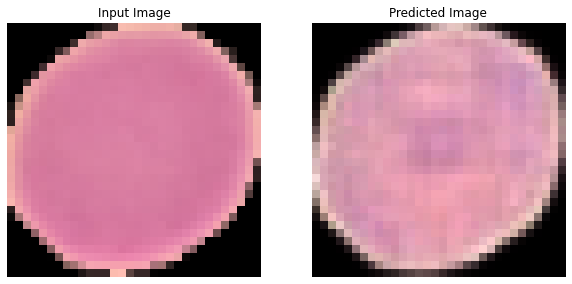

Saving checkpoint for epoch 600 at ./checkpoints/train/ckpt-12
Time taken for epoch 600 is 34.17365527153015 sec



In [ ]:
import time
from IPython.display import clear_output
from IPython import display

history = {}
history['class_loss_x'] = []
history['class_loss_y'] = []
history['cycle_loss'] = []
history['total_gen_g_loss'] = []
history['total_gen_f_loss'] = []
history['disc_loss_x'] = []
history['disc_loss_y'] = []
history['used_time'] = []

c_loss_x_mean = tfk.metrics.Mean()
c_loss_y_mean = tfk.metrics.Mean()
cycle_loss_mean = tfk.metrics.Mean()
total_gen_g_loss_mean = tfk.metrics.Mean()
total_gen_f_loss_mean = tfk.metrics.Mean()
disc_loss_x_mean = tfk.metrics.Mean()
disc_loss_y_mean = tfk.metrics.Mean()
uesed_time_mean = tfk.metrics.Mean()


for epoch in range(600):
  start = time.time()
  c_loss_x_mean.reset_state()
  c_loss_y_mean.reset_state()
  cycle_loss_mean.reset_state()
  total_gen_g_loss_mean.reset_state()
  total_gen_f_loss_mean.reset_state()
  disc_loss_x_mean.reset_state()
  disc_loss_y_mean.reset_state()
  uesed_time_mean.reset_state()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((x_dataset, y_dataset)):
    if (n % 10 == 0):
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, epoch, c_flag=True) # chang c_flag to False if want to remove the criterion
    else:
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, epoch=epoch, c_flag=False)
    c_loss_x_mean.update_state(c_loss_x)
    c_loss_y_mean.update_state(c_loss_y)
    cycle_loss_mean.update_state(total_cycle_loss)
    total_gen_g_loss_mean.update_state(total_gen_g_loss)
    total_gen_f_loss_mean.update_state(total_gen_f_loss)
    disc_loss_x_mean.update_state(disc_x_loss)
    disc_loss_y_mean.update_state(disc_y_loss)
    uesed_time_mean.update_state(time.time()-start)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, x_images, epoch)

  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  history['class_loss_x'].append(c_loss_x_mean.result().numpy())
  history['class_loss_y'].append(c_loss_y_mean.result().numpy())
  history['cycle_loss'].append(cycle_loss_mean.result().numpy())
  history['total_gen_g_loss'].append(total_gen_g_loss_mean.result().numpy())
  history['total_gen_f_loss'].append(total_gen_f_loss_mean.result().numpy())
  history['disc_loss_x'].append(disc_loss_x_mean.result().numpy())
  history['disc_loss_y'].append(disc_loss_y_mean.result().numpy())
  history['used_time'].append(uesed_time_mean.result().numpy())

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
generator_g.save('malaria_CycleGAN')
!zip -r malaria_CycleGAN.zip malaria_CycleGAN

  adding: malaria_CycleGAN/ (stored 0%)
  adding: malaria_CycleGAN/saved_model.pb (deflated 92%)
  adding: malaria_CycleGAN/keras_metadata.pb (deflated 96%)
  adding: malaria_CycleGAN/assets/ (stored 0%)
  adding: malaria_CycleGAN/variables/ (stored 0%)
  adding: malaria_CycleGAN/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: malaria_CycleGAN/variables/variables.index (deflated 63%)


In [ ]:
generator_f.save('normalcell_CycleGAN')
!zip -r normalcell_CycleGAN.zip normalcell_CycleGAN

  adding: normalcell_CycleGAN/ (stored 0%)
  adding: normalcell_CycleGAN/saved_model.pb (deflated 92%)
  adding: normalcell_CycleGAN/keras_metadata.pb (deflated 96%)
  adding: normalcell_CycleGAN/assets/ (stored 0%)
  adding: normalcell_CycleGAN/variables/ (stored 0%)
  adding: normalcell_CycleGAN/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: normalcell_CycleGAN/variables/variables.index (deflated 63%)


In [ ]:
!zip -r gen_images_cycleGAN.zip gen_images

  adding: gen_images/ (stored 0%)
  adding: gen_images/image_at_epoch_0246.png (deflated 26%)
  adding: gen_images/image_at_epoch_0373.png (deflated 27%)
  adding: gen_images/image_at_epoch_0086.png (deflated 27%)
  adding: gen_images/image_at_epoch_0438.png (deflated 27%)
  adding: gen_images/image_at_epoch_0348.png (deflated 26%)
  adding: gen_images/image_at_epoch_0090.png (deflated 26%)
  adding: gen_images/image_at_epoch_0363.png (deflated 26%)
  adding: gen_images/image_at_epoch_0161.png (deflated 26%)
  adding: gen_images/image_at_epoch_0559.png (deflated 26%)
  adding: gen_images/image_at_epoch_0370.png (deflated 26%)
  adding: gen_images/image_at_epoch_0569.png (deflated 27%)
  adding: gen_images/image_at_epoch_0343.png (deflated 26%)
  adding: gen_images/image_at_epoch_0532.png (deflated 26%)
  adding: gen_images/image_at_epoch_0355.png (deflated 26%)
  adding: gen_images/image_at_epoch_0204.png (deflated 26%)
  adding: gen_images/image_at_epoch_0173.png (deflated 25%)
  addi

Text(0.5, 51.00000000000006, 'epoch')

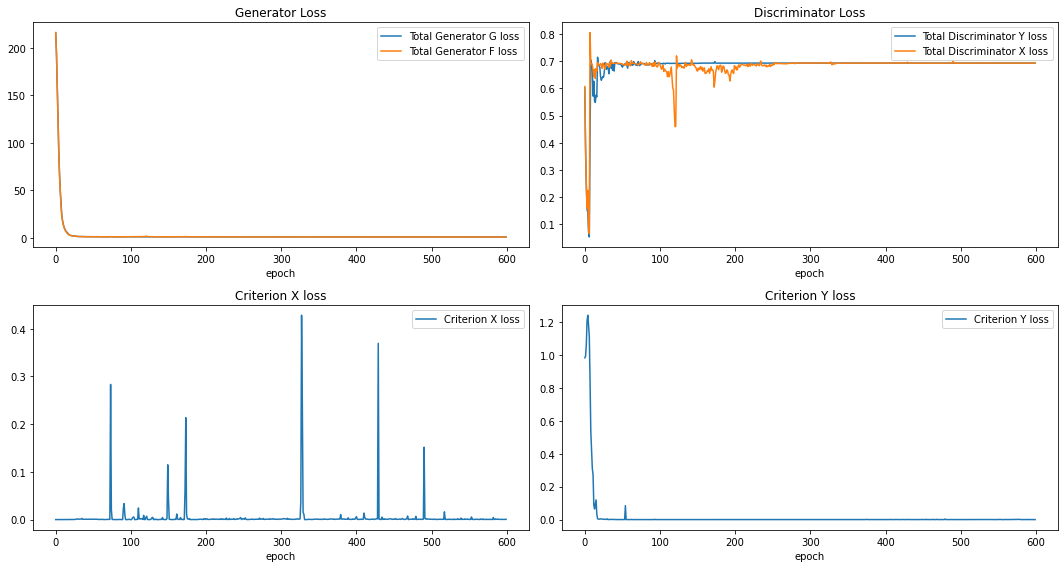

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(history['total_gen_g_loss'], label='Total Generator G loss')
plt.plot(history['total_gen_f_loss'], label='Total Generator F loss')
plt.legend(loc='best')
plt.title('Generator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 2)

plt.plot(history['disc_loss_y'], label='Total Discriminator Y loss')
plt.plot(history['disc_loss_x'], label='Total Discriminator X loss')
plt.legend(loc='best')
plt.title('Discriminator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)

plt.plot(history['class_loss_x'], label='Criterion X loss')
plt.legend(loc='best')
plt.title('Criterion X loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.tight_layout()
plt.plot(history['class_loss_y'], label='Criterion Y loss')
plt.legend(loc='best')
plt.title('Criterion Y loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

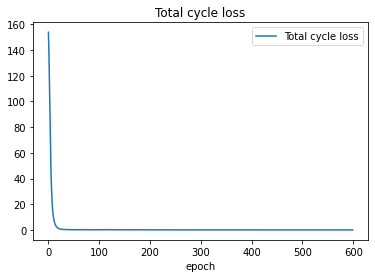

In [ ]:
plt.plot(history['cycle_loss'], label='Total cycle loss')
plt.legend(loc='best')
plt.title('Total cycle loss')
plt.xlabel('epoch')

Text(0, 0.5, 'second')

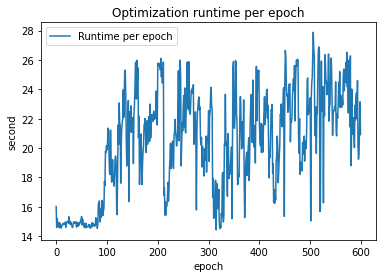

In [ ]:
plt.plot(history['used_time'], label='Runtime per epoch')
plt.legend(loc='best')
plt.title('Optimization runtime per epoch')
plt.xlabel('epoch')
plt.ylabel('second')

X --> Y by Gen G

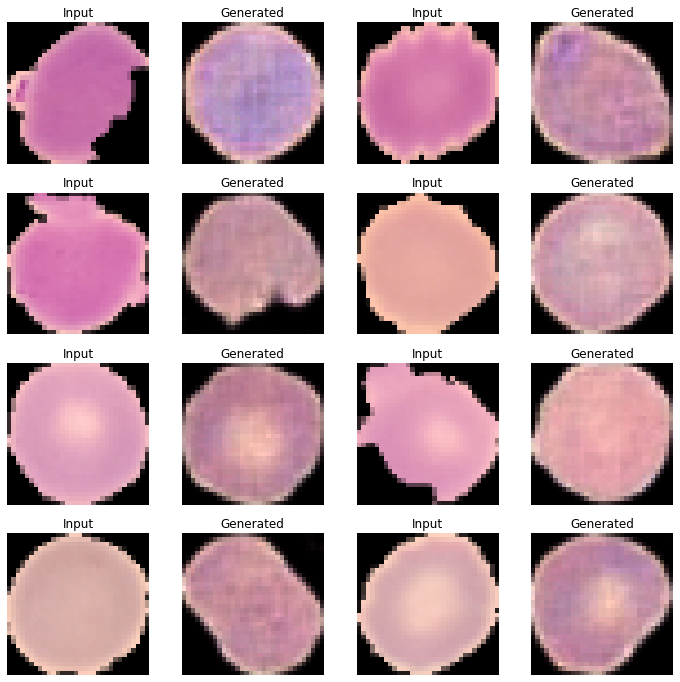

In [ ]:
n_images = next(iter(x_dataset))
gen_images = generator_g(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [ ]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []


for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

/usr/local/lib/python3.7/dist-packages/sewar/full_ref.py:248: RuntimeWarning: divide by zero encountered in true_divide
  rase_map = (100./M) * np.sqrt( np.sum(rmse_map**2,axis=2) / N )
/usr/local/lib/python3.7/dist-packages/sewar/full_ref.py:248: RuntimeWarning: invalid value encountered in multiply
  rase_map = (100./M) * np.sqrt( np.sum(rmse_map**2,axis=2) / N )


In [ ]:
MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

In [ ]:
print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 598.751594543457, std: 358.173840169204 
RMSE: ---- mean: 23.709756203149333, std: 6.049715309886807 
PSNR: ---- mean: 20.871010377362836, std: 1.9683527103776621 
UQI: ---- mean: 0.9808436799941094, std: 0.022762153999784575 
SCC: ---- mean: 0.5244893440893458, std: 0.05154847807806688 
RASE: ---- mean: nan, std: nan 
SAM: ---- mean: 0.13594412616318352, std: 0.028957731344081528 
VIF: ---- mean: 0.30427535147926976, std: 0.08352449244814297 


In [ ]:
preds = classifier(gen_images)
true_labels = tf.ones([256,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 0.99609375


Y --> Y by Gen G

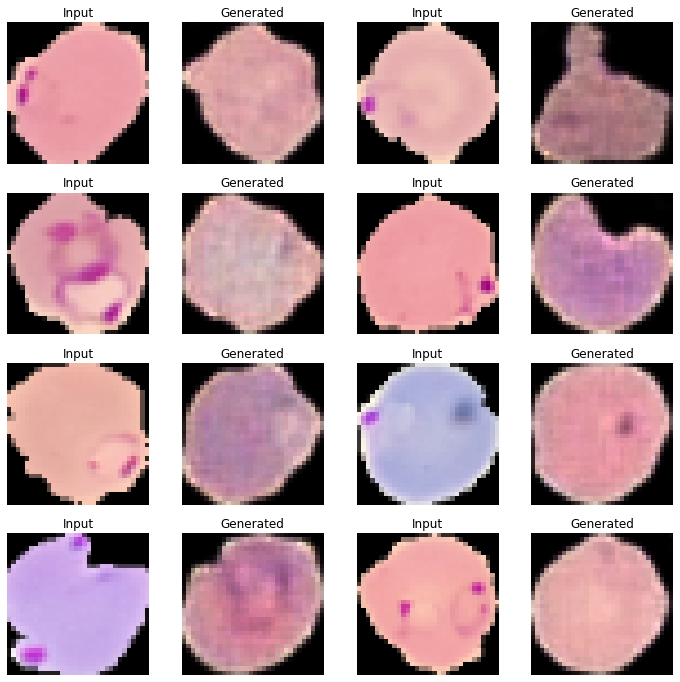

In [ ]:
n_images = next(iter(y_dataset))
gen_images = generator_g(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [ ]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []


for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")



MSE ---- mean: 710.6980018615723, std: 578.5892647367449 
RMSE: ---- mean: 25.28001197804158, std: 8.462800733306114 
PSNR: ---- mean: 20.466720419906856, std: 2.492499417808938 
UQI: ---- mean: 0.977660559598589, std: 0.03874322387658942 
SCC: ---- mean: 0.5560266912829032, std: 0.05629823381612695 
RASE: ---- mean: nan, std: nan 
SAM: ---- mean: 0.12872371035951857, std: 0.024348812379888306 
VIF: ---- mean: 0.3465425577959367, std: 0.05777754850814237 


In [ ]:
preds = classifier(gen_images)
true_labels = tf.ones([256,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 1.0


Y --> X by Gen F

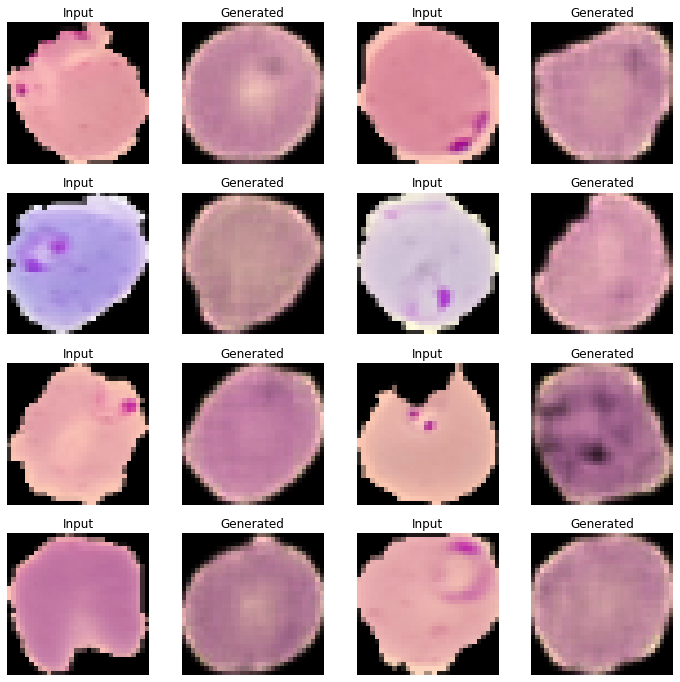

In [ ]:
n_images = next(iter(y_dataset))
gen_images = generator_f(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [ ]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []


for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 1125.1133728027344, std: 736.5729912651761 
RMSE: ---- mean: 32.05396559571545, std: 9.8821385535432 
PSNR: ---- mean: 18.401049112322532, std: 2.57864387007862 
UQI: ---- mean: 0.9613792477367493, std: 0.030834558364478477 
SCC: ---- mean: 0.528695191805431, std: 0.06583032071853086 
RASE: ---- mean: nan, std: nan 
SAM: ---- mean: 0.13854333342310415, std: 0.029771647043740086 
VIF: ---- mean: 0.3355543331056473, std: 0.0665450266977963 


In [ ]:
preds = classifier(gen_images)
true_labels = tf.zeros([256,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 0.93359375


X --> X by Gen F

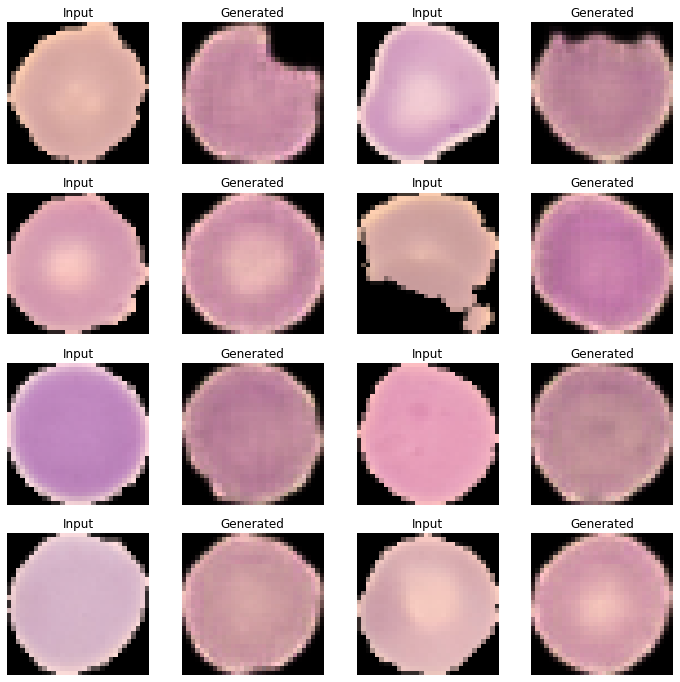

In [ ]:
n_images = next(iter(x_dataset))
gen_images = generator_f(n_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(n_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(gen_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [ ]:
input_images = []
generated_images = []
for i in range(n_images.shape[0]):
  input_images.append(tf.keras.preprocessing.image.array_to_img(n_images[i, :, :, :]).convert('L'))
  generated_images.append(tf.keras.preprocessing.image.array_to_img(gen_images[i, :, :, :]).convert('L'))

MSE = []
RMSE = []
PSNR = []
UQI = []
SCC = []
RASE =[]
SAM = []
VIF = []


for j in range(len(input_images)):
  gen = tf.keras.preprocessing.image.img_to_array(generated_images[j]).astype('uint8')
  org = tf.keras.preprocessing.image.img_to_array(input_images[j]).astype('uint8')
  MSE.append(mse(gen,org))
  RMSE.append(rmse(gen, org))
  PSNR.append(psnr(gen, org))
  UQI.append(uqi(gen, org))
  SCC.append(scc(gen, org))
  RASE.append(rase(gen, org))
  SAM.append(sam(gen, org))
  VIF.append(vifp(gen, org))

MSE = np.array(MSE)
RMSE = np.array(RMSE)
PSNR = np.array(PSNR)
UQI = np.array(UQI)
SCC = np.array(SCC)
RASE = np.array(RASE)
SAM = np.array(SAM)
VIF = np.array(VIF)

print(f"MSE ---- mean: {MSE.mean()}, std: {MSE.std()} ")
print(f"RMSE: ---- mean: {RMSE.mean()}, std: {RMSE.std()} ")
print(f"PSNR: ---- mean: {PSNR.mean()}, std: {PSNR.std()} ")
print(f"UQI: ---- mean: {UQI.mean()}, std: {UQI.std()} ")
print(f"SCC: ---- mean: {SCC.mean()}, std: {SCC.std()} ")
print(f"RASE: ---- mean: {RASE.mean()}, std: {RASE.std()} ")
print(f"SAM: ---- mean: {SAM.mean()}, std: {SAM.std()} ")
print(f"VIF: ---- mean: {VIF.mean()}, std: {VIF.std()} ")

MSE ---- mean: 627.0558204650879, std: 353.424003165992 
RMSE: ---- mean: 24.17433927227968, std: 6.531243466125284 
PSNR: ---- mean: 20.772921696381466, std: 2.3230830396182243 
UQI: ---- mean: 0.9779253538110833, std: 0.021908636078738206 
SCC: ---- mean: 0.5544255272689389, std: 0.06332356197327994 
RASE: ---- mean: nan, std: nan 
SAM: ---- mean: 0.11982730852838289, std: 0.02955785706699814 
VIF: ---- mean: 0.4475785497771697, std: 0.09413459198574037 


In [ ]:
preds = classifier(gen_images)
true_labels = tf.zeros([256,1])
print(f"classify accuracy: {get_accuracy(true_labels, preds)}")

classify accuracy: 0.99609375


FID score

In [ ]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.datasets import cifar10

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = tf.image.resize(image, new_shape)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
FID = []
for images in x_testset:
  images1 = images
  images2 = generator_g(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Cycle GAN X to Y by Gen G ------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Cycle GAN X to Y by Gen G ------
Adjusted FID Mean: 4.241632229046489e-06, Std: 1.9488772429746635e-07


In [ ]:
FID = []
for images in y_testset:
  images1 = images
  images2 = generator_g(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Cycle GAN Y to Y by Gen G ------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Cycle GAN Y to Y by Gen G ------
Adjusted FID Mean: 9.324277847307066e-06, Std: 2.9913133944853046e-07


In [ ]:
FID = []
for images in y_testset:
  images1 = images
  images2 = generator_f(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Cycle GAN Y to X by Gen F ------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Cycle GAN Y to X by Gen F ------
Adjusted FID Mean: 1.2321025776400372e-05, Std: 3.108465593305233e-06


In [ ]:
FID = []
for images in x_testset:
  images1 = images
  images2 = generator_f(images)
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  fid = calculate_fid(classifier, images1, images2)
  FID.append(fid)

FID = np.array(FID)
print("Cycle GAN X to X by Gen F ------")
print(f'Adjusted FID Mean: {FID.mean()}, Std: {FID.std()}')

Cycle GAN X to X by Gen F ------
Adjusted FID Mean: 7.737509083740804e-06, Std: 2.139823229062015e-06
